In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
print(sys.version)

3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
data = pd.read_pickle(os.getcwd() + '/pickle/wow_player_stats_cleaned.pkl')

# Which Races, Classes and Factions are Favored Over Others?

In [30]:
df = data[(data['race'] != 'NaN') &\
          (data['level'] == '110')][['race-class','race','class','faction','min_date','max_date']].copy()

In [35]:
df.describe()

,race-class,race,class,faction,min_date,max_date
count,414487,414487,414487,414487,414487,414487
unique,111,13,11,3,349476,332870
top,Night Elf Druid,Blood Elf,Hunter,Alliance,2017-06-13 22:16:00,2017-06-13 22:16:00
freq,21983,81371,69746,201283,28,44


In [38]:
df['race'].nunique()

13

We'd expect the pool of players to be uniformly distributed across these 13 races, such that the proportion of players posting as each race should be 1/13, or roughly 7.7 percent.

In [119]:
def category_probabilities(data, column_name):
    """Calculates categorical variable probabilities
    from a pandas DataFrame.
    ----- Args:
            pandas.DataFrame and column title as string.
    ----- Returns:
            pandas DataFrame containing probabilities and logits.
    """
    s = data[column_name]
    probs = s.value_counts(normalize=True).to_frame('p_true') #actual probabilities
    probs['p_expected'] = probs.shape[0] * [1 / s.nunique()] #expected probabilities
    probs['p_shift'] = probs['p_true'] - probs['p_expected']
    
    logit = lambda p: np.log(p / (1 - p))
    probs['logit_true'] = probs['p_true'].transform(logit)
    return probs

#### Race Distribution

In [120]:
race_probs = category_probabilities(data=df, column_name='race')

In [122]:
race_probs

,p_true,p_expected,p_shift,logit_true
Blood Elf,0.196317,0.076923,0.119394,-1.409472
Human,0.184739,0.076923,0.107816,-1.484563
Night Elf,0.142178,0.076923,0.065255,-1.797315
Orc,0.084553,0.076923,0.007630,-2.382038
Tauren,0.068641,0.076923,-0.008282,-2.607747
Troll,0.058180,0.076923,-0.018743,-2.784266
Draenei,0.057845,0.076923,-0.019078,-2.790403
Undead,0.054865,0.076923,-0.022058,-2.846444
Dwarf,0.037094,0.076923,-0.039829,-3.256499
Worgen,0.034795,0.076923,-0.042128,-3.322872


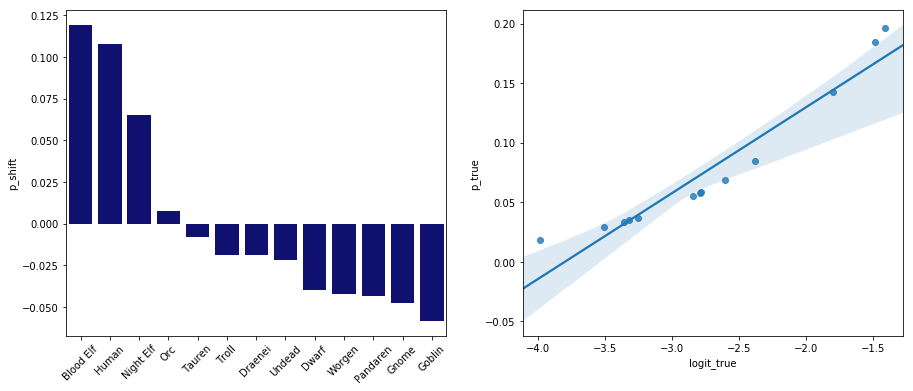

In [123]:
fig, axes = plt.subplots(ncols=2, figsize=(15,6))
plot1 = sns.barplot(race_probs.index, race_probs.p_shift, color='navy', ax=axes[0])
plt.setp(plot1.get_xticklabels(), rotation=45)

plot2 = sns.regplot(x=race_probs.logit_true, y=race_probs.p_true, ax=axes[1])
plt.show()

Players have higher likelihoods of playing Blood Elf, Human or Night Elf compared to the other races. Orc and Tauren come closest to their expected probabilities. Goblin and Gnome are the least likely to be played. 

#### Class Distribution

In [124]:
class_probs = category_probabilities(data=df, column_name='class')

In [125]:
class_probs

,p_true,p_expected,p_shift,logit_true
Hunter,0.168271,0.090909,0.077362,-1.597933
Paladin,0.118370,0.090909,0.027461,-2.007953
Druid,0.116607,0.090909,0.025698,-2.024963
Warrior,0.095002,0.090909,0.004093,-2.254037
Death Knight,0.080755,0.090909,-0.010154,-2.432129
Mage,0.079409,0.090909,-0.011500,-2.450404
Priest,0.077614,0.090909,-0.013295,-2.475216
Shaman,0.077131,0.090909,-0.013778,-2.481975
Warlock,0.069515,0.090909,-0.021394,-2.594166
Rogue,0.067218,0.090909,-0.023691,-2.630230


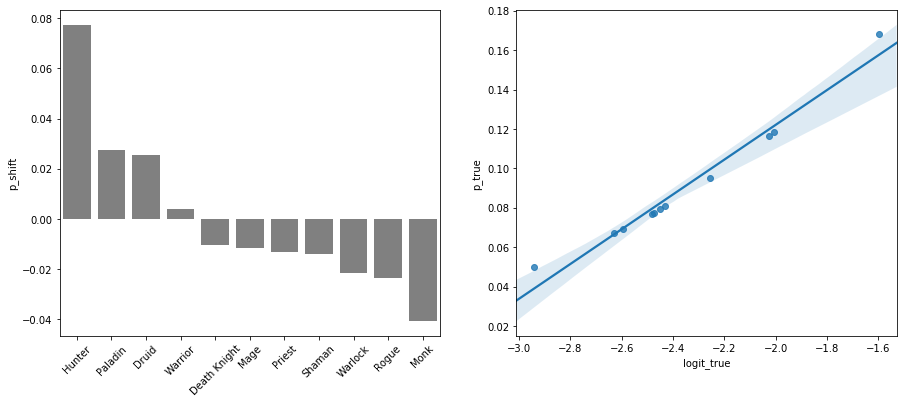

In [126]:
fig, axes = plt.subplots(ncols=2, figsize=(15,6))
plot1 = sns.barplot(class_probs.index, class_probs.p_shift, color='grey', ax=axes[0])
plt.setp(plot1.get_xticklabels(), rotation=45)

plot2 = sns.regplot(x=class_probs.logit_true, y=class_probs.p_true, ax=axes[1])
plt.show()

Players have higher likelihoods of playing Hunter, Paladin or Druid compared to the other classes with Hunter being pretty dominant over the second most popular class, Paladin. Actual proportions for the Warrior class come close to its expected proportion and Monk and Rogue are the least probable classes to see.

#### Race and Class Combinations

In [127]:
combo_probs = category_probabilities(data=df, column_name='race-class')

In [149]:
combo_probs.head()

,p_true,p_expected,p_shift,logit_true
Night Elf Druid,0.053037,0.009009,0.044028,-2.882277
Human Paladin,0.047295,0.009009,0.038286,-3.002909
Blood Elf Paladin,0.045258,0.009009,0.036249,-3.049053
Blood Elf Demon Hunter,0.032184,0.009009,0.023175,-3.403561
Tauren Druid,0.031241,0.009009,0.022232,-3.434284


In [150]:
#Matrix multiplication between race and class probability frames to compare to race-class frame.
race_probs[['p_true']].dot(class_probs[['p_true']].T).unstack().reset_index().sort_values(by=0,ascending=False).head()

,level_0,level_1,0
0,Hunter,Blood Elf,0.033034
1,Hunter,Human,0.031086
2,Hunter,Night Elf,0.023924
13,Paladin,Blood Elf,0.023238
26,Druid,Blood Elf,0.022892
